<a href="https://colab.research.google.com/github/Jundo22l/CAU_internship/blob/main/U_NET_with_VOC_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import vgg16
import torchvision.transforms.functional as TVF
import glob

# 문제 발생 시 CUDA 동기적으로 에러 출력
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [20]:
# 데이터셋 다운로드 및 압축 해제
!wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar

# COLOR_2_INDEX 및 CLASS_NAMES 정의 (PASCAL VOC 2012)
COLOR_2_INDEX = {
    (0, 0, 0): 0,            # Background
    (128, 0, 0): 1,          # Aeroplane
    (0, 128, 0): 2,          # Bicycle
    (128, 128, 0): 3,        # Bird
    (0, 0, 128): 4,          # Boat
    (128, 0, 128): 5,        # Bottle
    (0, 128, 128): 6,        # Bus
    (128, 128, 128): 7,      # Car
    (64, 0, 0): 8,           # Cat
    (192, 0, 0): 9,          # Chair
    (64, 128, 0): 10,        # Cow
    (192, 128, 0): 11,       # Dining Table
    (64, 0, 128): 12,        # Dog
    (192, 0, 128): 13,       # Horse
    (64, 128, 128): 14,      # Motorbike
    (192, 128, 128): 15,     # Person
    (0, 64, 0): 16,          # Potted Plant
    (128, 64, 0): 17,        # Sheep
    (0, 192, 0): 18,         # Sofa
    (128, 192, 0): 19,       # Train
    (0, 64, 128): 20         # TV/Monitor
}
CLASS_NAMES = ["Background", "Aeroplane", "Bicycle", "Bird", "Boat", "Bottle", "Bus", "Car", "Cat", "Chair", "Cow",
               "Dining Table", "Dog", "Horse", "Motorbike", "Person", "Potted Plant", "Sheep", "Sofa", "Train", "TV/Monitor"]

In [21]:
class PascalVoc(Dataset):
    def __init__(self, path, img_size, device="cuda"):
        # 초기화 함수로 데이터셋 경로, 이미지 크기, 사용할 장치를 설정한다.
        self.seg_folder = "SegmentationClass/"  # SegmentationClass 폴더 경로
        self.img_folder = "JPEGImages/"  # JPEGImages 폴더 경로
        self.path = path  # 데이터셋의 기본 경로
        self.device = device  # 사용할 장치(CUDA 또는 CPU)

        # SegmentationClass 폴더 내의 모든 이미지 경로를 가져온다.
        self.segmentation_imgs = glob.glob(os.path.join(path, self.seg_folder, "*"))
        self.img_size = img_size  # 이미지 크기 설정

    def __len__(self):
        # 데이터셋의 전체 샘플 수를 반환한다.
        return len(self.segmentation_imgs)

    def get_paths(self, idx):
        # 주어진 인덱스에 해당하는 이미지와 마스크 경로를 반환한다.
        mask_path = self.segmentation_imgs[idx]  # 인덱스에 해당하는 마스크 이미지 경로

        # 마스크 이미지 파일 이름을 가져온다.
        file_name = mask_path.split("/")[-1]
        # JPEGImages 폴더에서 해당하는 원본 이미지 경로를 만든다.
        img_path = os.path.join(self.path, self.img_folder, file_name.split(".")[0] + ".jpg")

        # 원본 이미지 경로와 마스크 이미지 경로를 튜플로 반환한다.
        return (img_path, mask_path)

    def load_imgs(self, idx):
        # 주어진 인덱스에 해당하는 원본 이미지와 마스크 이미지를 로드하여 반환한다.
        img_path, mask_path = self.get_paths(idx)  # 인덱스에 해당하는 이미지와 마스크 경로를 가져온다.

        # 원본 이미지를 로드하고, 지정된 크기로 리사이즈한다.
        img = Image.open(img_path)
        img = img.resize((self.img_size, self.img_size))

        # 마스크 이미지를 로드하고, RGB로 변환한 후 지정된 크기로 리사이즈한다.
        mask_img = Image.open(mask_path).convert("RGB")
        mask_img = mask_img.resize((self.img_size, self.img_size))

        # 원본 이미지와 마스크 이미지를 튜플로 반환한다.
        return (img, mask_img)

    @staticmethod
    def create_label_mask(mask_img):
        # 마스크 이미지를 정수형 NumPy 배열로 변환하고, 레이블 마스크를 생성한다.
        mask = np.array(mask_img).astype(int)  # 마스크 이미지를 NumPy 배열로 변환
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)  # 빈 레이블 마스크 초기화

        # COLOR_2_INDEX에 따라 마스크 이미지의 각 픽셀에 레이블을 할당한다.
        for idx, label in enumerate(COLOR_2_INDEX):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = idx

        label_mask = label_mask.astype(int)  # 레이블 마스크를 정수형으로 변환
        return label_mask  # 레이블 마스크 반환

    def __getitem__(self, idx):
        # 주어진 인덱스에 해당하는 데이터를 반환하는 함수로, 데이터 증강을 포함한다.
        img, mask_img = self.load_imgs(idx)  # 이미지와 마스크를 로드한다.

        # 랜덤으로 이미지를 좌우 반전시킨다 (데이터 증강).
        if random.random() > 0.5:
            img = TVF.hflip(img)
            mask_img = TVF.hflip(mask_img)

        # 마스크 이미지를 레이블 마스크로 변환하고, 텐서로 변환한다.
        mask_img = PascalVoc.create_label_mask(mask_img)
        mask_img = torch.from_numpy(mask_img).long()

        # 이미지를 텐서로 변환하고, 정규화한다.
        img = TVF.to_tensor(img)
        img = TVF.normalize(img,
                            mean=(0.485, 0.456, 0.406),
                            std=(0.229, 0.224, 0.225)
                           )

        # 이미지와 마스크를 지정된 장치로 이동시킨다.
        img = img.to(self.device)
        mask_img = mask_img.to(self.device)

        # 이미지와 마스크를 튜플로 반환한다.
        return (img, mask_img)

In [22]:
# 2D 합성곱(convolution)과 배치 정규화(batch normalization) 레이어를 정의하는 클래스
class conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 2D 합성곱 레이어를 정의한다.
        # 입력 채널 수(in_channels)에서 출력 채널 수(out_channels)로 변환하며,
        # 커널 크기는 3x3, 스트라이드는 1, 패딩은 1로 설정되어 있다.
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

        # 배치 정규화 레이어를 정의한다. 출력 채널 수를 기준으로 배치 정규화를 수행한다.
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # 입력 데이터 x에 대해 합성곱 연산을 수행한다.
        x = self.conv(x)

        # ReLU 활성화 함수를 적용하여 비선형성을 추가한다.
        x = F.relu(x)

        # 배치 정규화를 수행하여 데이터의 분포를 정규화한다.
        x = self.bn(x)

        # 최종 결과를 반환한다.
        return x

# 2D 전치 합성곱(transposed convolution)과 배치 정규화 레이어를 정의하는 클래스
class trans_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 2D 전치 합성곱 레이어를 정의한다.
        # 전치 합성곱은 일반 합성곱의 반대 방향으로 작동하며, 보통 업샘플링(upsampling)에 사용된다.
        # 입력 채널 수(in_channels)에서 출력 채널 수(out_channels)로 변환하며,
        # 커널 크기는 3x3, 스트라이드는 2, 패딩은 1, 출력 패딩은 1로 설정되어 있다.
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,
                                       kernel_size=3, stride=2,
                                       padding=1, output_padding=1)

        # 배치 정규화 레이어를 정의한다. 출력 채널 수를 기준으로 배치 정규화를 수행한다.
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # 입력 데이터 x에 대해 전치 합성곱 연산을 수행한다.
        x = self.conv(x)

        # ReLU 활성화 함수를 적용하여 비선형성을 추가한다.
        x = F.relu(x)

        # 배치 정규화를 수행하여 데이터의 분포를 정규화한다.
        x = self.bn(x)

        # 최종 결과를 반환한다.
        return x

In [23]:
class u_net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # U-Net의 출력 클래스 수를 정의한다.
        self.num_classes = num_classes

        # U-Net에서 사용할 VGG 블록의 인덱스를 정의한다.
        self.un_block_indicies = [(0, 4), (5, 9), (10, 16),
                                   (17, 23), (24, 30)]

        # VGG16 모델 초기화를 위한 메서드 호출
        self.init_vgg()

        # U-Net의 중간 레이어에 사용할 2개의 7x7 컨볼루션 레이어를 정의한다.
        self.conv_7x7_1 = conv2d(512, 512)
        self.conv_7x7_2 = conv2d(512, 512)

        # 업샘플링을 위한 전치 합성곱 레이어 정의 (5개)
        self.trans_conv_1 = trans_conv2d(512, 256)
        self.trans_conv_2 = trans_conv2d(512, 256)
        self.trans_conv_3 = trans_conv2d(512, 128)
        self.trans_conv_4 = trans_conv2d(256, 64)
        self.trans_conv_5 = trans_conv2d(128, 32)

        # 다운샘플링 경로와 업샘플링 경로의 출력 채널을 결합하기 위한 컨볼루션 레이어 정의 (4개)
        self.conv_1 = conv2d(256 + 512, 512)
        self.conv_2 = conv2d(256 + 512, 512)
        self.conv_3 = conv2d(128 + 256, 256)
        self.conv_4 = conv2d(64 + 128, 128)

        # 최종 출력을 생성하기 위한 1x1 컨볼루션 레이어 정의
        self.out_conv = nn.Conv2d(32 + 64, num_classes, stride=1, kernel_size=1)

    def init_vgg(self):
        # 사전 학습된 VGG16 모델을 불러온다.
        model = vgg16(pretrained=True)
        # VGG16의 classifier 부분을 제거하여 feature extractor로만 사용한다.
        del model.classifier
        model = model.to(device)

        self.blocks = []

        # 지정된 인덱스에 따라 VGG16의 각 블록을 나눈다.
        for block_idx in self.un_block_indicies:
            self.blocks.append(model.features[block_idx[0]:block_idx[1]])

        # VGG16의 가중치를 고정하여 학습 중 업데이트되지 않도록 한다.
        for block in self.blocks:
            for param in block.parameters():
                param.requires_grad = False

    def forward(self, x):
        # U-Net의 인코더(다운샘플링) 부분
        x_1 = self.blocks[0](x)  # 첫 번째 VGG 블록을 통과한 결과
        encoder = F.max_pool2d(x_1, kernel_size=2, stride=2)  # Max Pooling
        x_2 = self.blocks[1](encoder)  # 두 번째 VGG 블록을 통과한 결과
        encoder = F.max_pool2d(x_2, kernel_size=2, stride=2)
        x_3 = self.blocks[2](encoder)  # 세 번째 VGG 블록을 통과한 결과
        encoder = F.max_pool2d(x_3, kernel_size=2, stride=2)
        x_4 = self.blocks[3](encoder)  # 네 번째 VGG 블록을 통과한 결과
        encoder = F.max_pool2d(x_4, kernel_size=2, stride=2)
        x_5 = self.blocks[4](encoder)  # 다섯 번째 VGG 블록을 통과한 결과
        encoder = F.max_pool2d(x_5, kernel_size=2, stride=2)

        # U-Net의 중간 레이어 (7x7 컨볼루션 2개)
        encoder = self.conv_7x7_1(encoder)
        encoder = self.conv_7x7_2(encoder)

        # U-Net의 디코더(업샘플링) 부분
        decoder = self.trans_conv_1(encoder)  # 전치 합성곱으로 업샘플링
        decoder = torch.cat((decoder, x_5), dim=1)  # 대응하는 인코더의 출력을 결합 (스킵 연결)
        decoder = self.conv_1(decoder)  # 결합된 출력에 대해 컨볼루션 적용

        decoder = self.trans_conv_2(decoder)
        decoder = torch.cat((decoder, x_4), dim=1)
        decoder = self.conv_2(decoder)

        decoder = self.trans_conv_3(decoder)
        decoder = torch.cat((decoder, x_3), dim=1)
        decoder = self.conv_3(decoder)

        decoder = self.trans_conv_4(decoder)
        decoder = torch.cat((decoder, x_2), dim=1)
        decoder = self.conv_4(decoder)

        decoder = self.trans_conv_5(decoder)
        decoder = torch.cat((decoder, x_1), dim=1)
        decoder = self.out_conv(decoder)  # 최종 출력 생성

        # 출력에 대해 소프트맥스 적용 (로그 확률로 반환)
        score = F.log_softmax(decoder, dim=1)
        return score

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-25-7774da5c0527>:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = amp.GradScaler(enabled=amp_enabled)
<ipython-input-25-7774da5c0527>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with am

-------Epoch 1-------
Loss : 1.0337228483479957
Mean IOU: 0.3922348793728617
-------Epoch 2-------
Loss : 0.7338705568209939
Mean IOU: 0.48695177736371364
-------Epoch 3-------
Loss : 0.6534370161269022
Mean IOU: 0.51801750011187
-------Epoch 4-------
Loss : 0.6149569536032884
Mean IOU: 0.5359650649060572
-------Epoch 5-------
Loss : 0.5858521493880645
Mean IOU: 0.5480126731593128
-------Epoch 6-------
Loss : 0.558410275241603
Mean IOU: 0.5599999264809233
-------Epoch 7-------
Loss : 0.5266778498240139
Mean IOU: 0.5794327547433585
-------Epoch 8-------
Loss : 0.502138712807842
Mean IOU: 0.5899744620148727
-------Epoch 9-------
Loss : 0.48197653922049893
Mean IOU: 0.5992275198313384
-------Epoch 10-------
Loss : 0.45641703061435535
Mean IOU: 0.6104844894143918
-------Epoch 11-------
Loss : 0.4394442798650783
Mean IOU: 0.6178089666704404
-------Epoch 12-------
Loss : 0.4252714210230371
Mean IOU: 0.625359874256836
-------Epoch 13-------
Loss : 0.4210132101307745
Mean IOU: 0.62674389020512

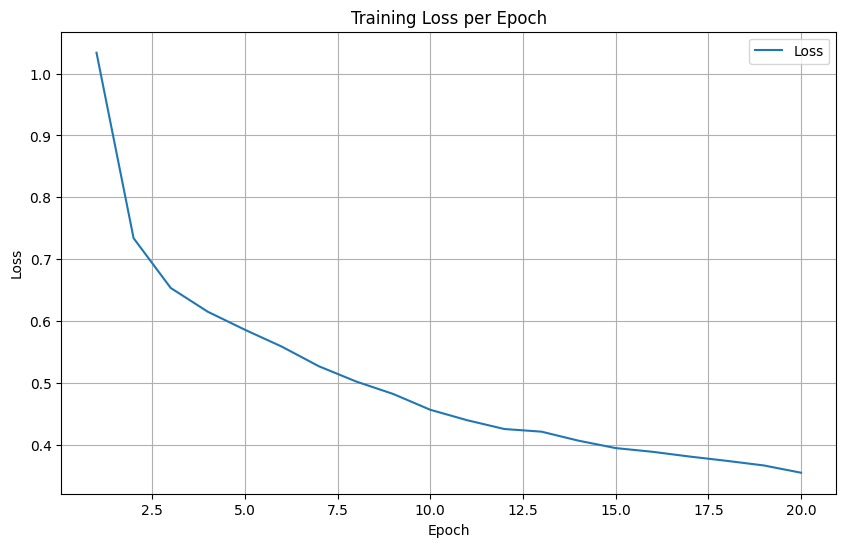

In [25]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.cuda.amp as amp

# 시드 설정
seed = 42
torch.manual_seed(seed)

# 하드웨어 장치 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 이미지 크기 및 배치 크기 설정
img_size = 224
batch_size = 32

# PascalVoc 데이터셋을 불러오고 DataLoader를 설정
train_dataset = PascalVoc("VOCdevkit/VOC2012/", img_size, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0)

# u_net 모델 정의 및 클래스 수에 맞게 초기화
model = u_net(len(CLASS_NAMES)).to(device)

# 학습 설정
learning_rate = 2e-3  # 초기 학습률
weight_decay = 1e-5  # L2 정규화
momentum = 0.9  # RMSprop 모멘텀
amp_enabled = True  # AMP 사용 여부 (혼합 정밀도 학습)

# 옵티마이저를 RMSprop으로 설정 (기존 Adam에서 변경)
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)

# 학습률 스케줄러를 ReduceLROnPlateau로 설정
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5)

# GradScaler를 사용한 혼합 정밀도 학습 설정
grad_scaler = amp.GradScaler(enabled=amp_enabled)

# 손실 함수 설정: 클래스 개수에 따라 CrossEntropy 또는 BCEWithLogits 선택
criterion = nn.CrossEntropyLoss() if model.num_classes > 1 else nn.BCEWithLogitsLoss()

# IoU 계산 함수 정의
def batch_mean_iou(preds, labels):
    intersection = np.logical_and(preds, labels)  # 교집합 계산
    union = np.logical_or(preds, labels)  # 합집합 계산
    iou_score = np.sum(intersection) / np.sum(union)  # IoU 계산
    return iou_score

# 학습 기록을 저장할 리스트 생성
loss_history = []
iou_history = []

# 에포크 반복 학습
num_epochs = 20

# 모델을 학습 모드로 전환
model.train()

for epoch in range(1, num_epochs + 1):
    loss = 0.0  # 에포크 당 손실을 저장할 변수 초기화
    iou = 0.0  # 에포크 당 IoU를 저장할 변수 초기화

    # 데이터 로더를 통해 미니배치 학습
    for _, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()  # 가중치 초기화

        # 자동 혼합 정밀도 학습 활성화
        with amp.autocast(enabled=amp_enabled):
            y_hat = model(x)  # 모델을 통해 예측값 생성
            batch_loss = criterion(y_hat, y)  # 예측값과 실제값 간의 손실 계산

        # 손실 스케일링 및 역전파
        grad_scaler.scale(batch_loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()

        # 현재 배치의 손실을 numpy 형식으로 변환하여 손실 변수에 추가
        batch_loss = batch_loss.detach().cpu().numpy()
        loss += batch_loss

        # 예측값을 클래스별로 가장 높은 값으로 변환
        preds = torch.argmax(y_hat, dim=1)

        # 현재 배치의 IoU 계산
        batch_iou = batch_mean_iou(preds.detach().cpu().numpy(), y.detach().cpu().numpy())
        iou += batch_iou  # 에포크 IoU에 추가

    # 에포크가 끝날 때마다 평균 손실과 평균 IoU 계산
    loss = loss / len(train_dataloader)
    iou = iou / len(train_dataloader)

    # 손실과 IoU 기록 저장
    loss_history.append(loss)
    iou_history.append(iou)

    # 학습률 스케줄러 업데이트 (ReduceLROnPlateau는 성능에 따라 학습률을 조정)
    scheduler.step(iou)

    # 1 epoch마다 손실과 IoU 출력
    print(f"-------Epoch {epoch}-------")
    print(f"Loss : {loss}")
    print(f"Mean IOU: {iou}")

# 학습이 끝난 후 손실 값 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

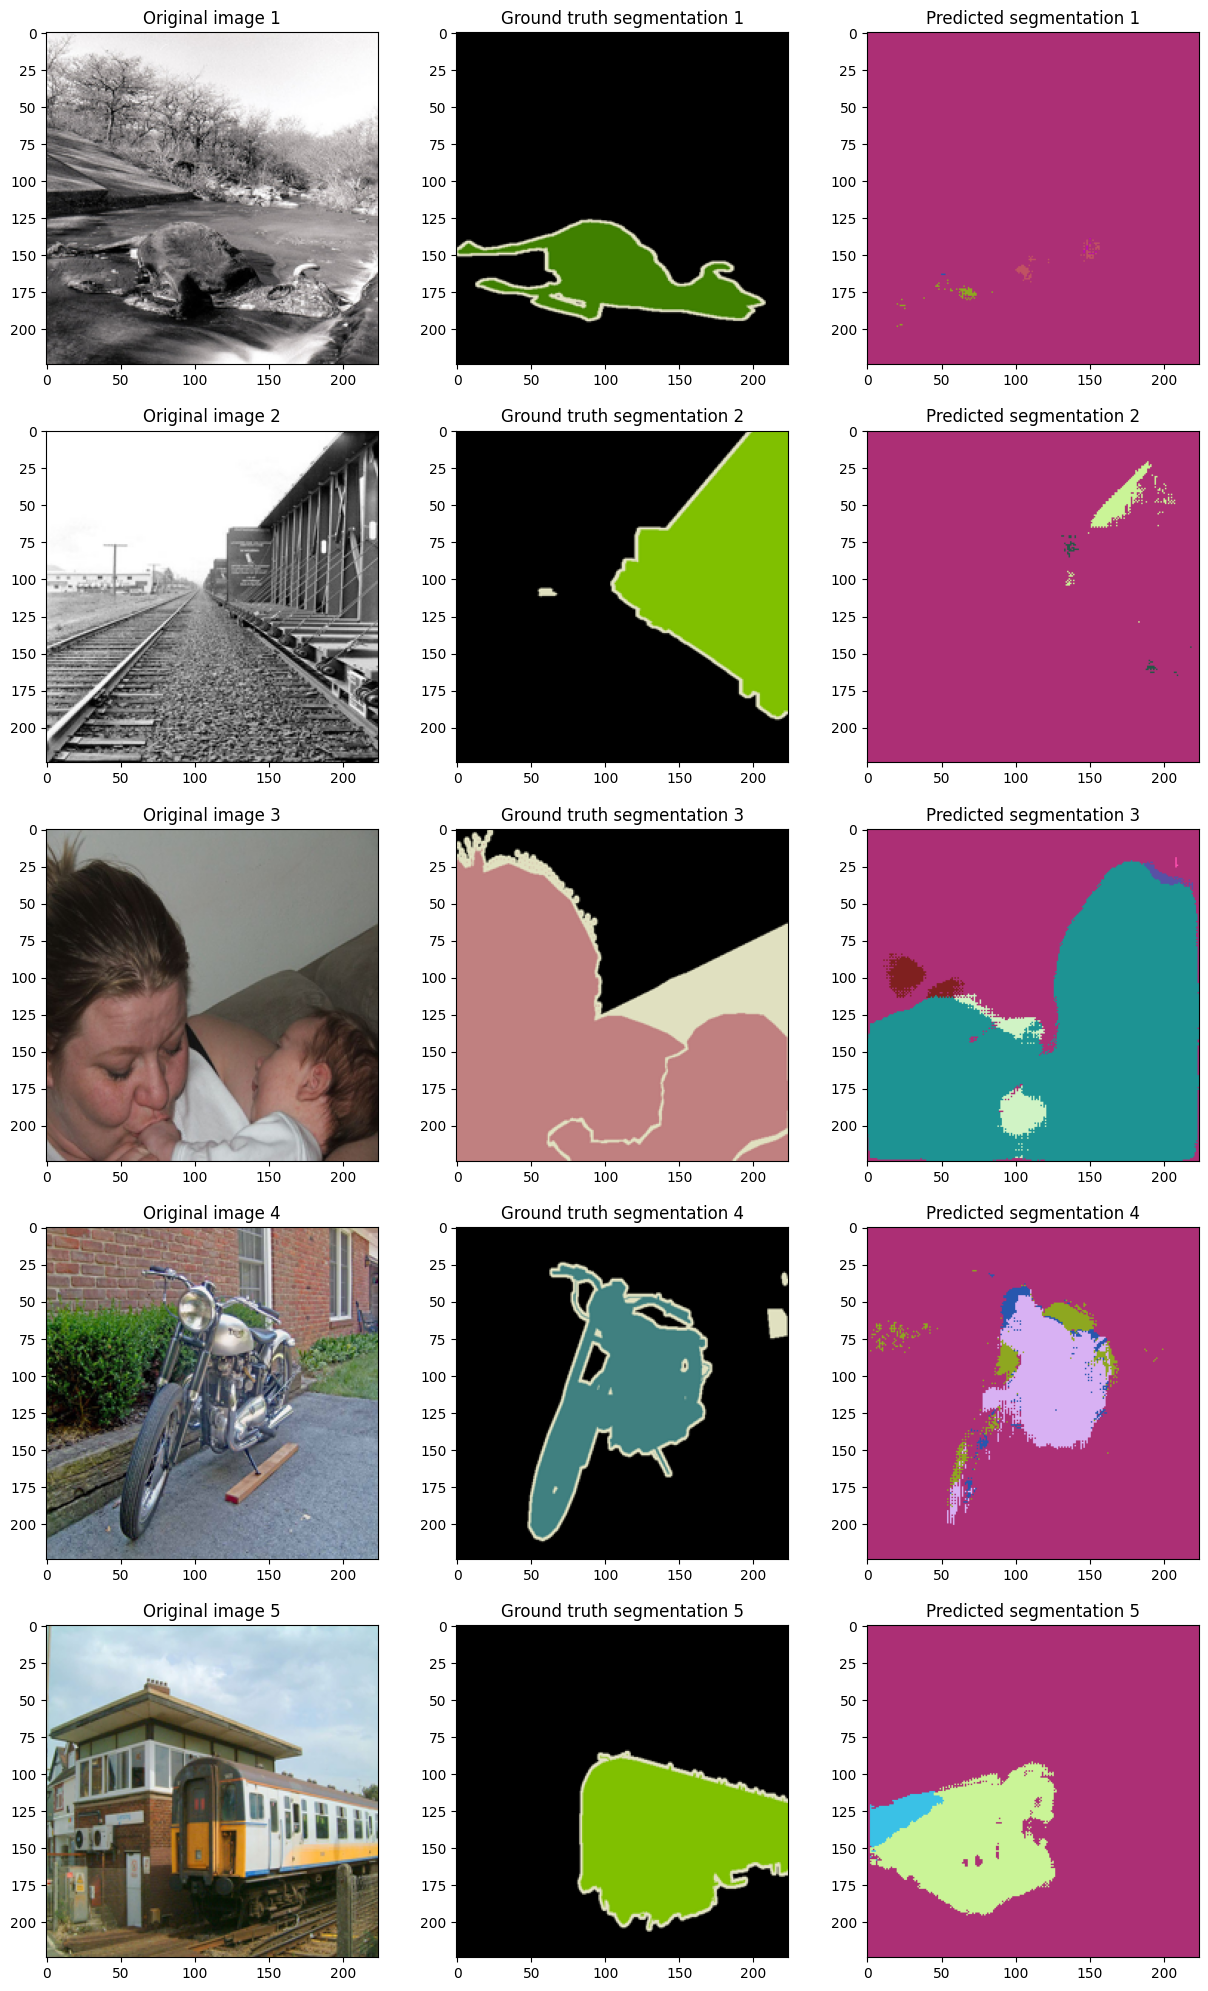

In [28]:
def create_color_index(num_classes):
    np.random.seed(0)  # 결과 재현성을 위해 시드 고정
    color_map = {}
    for i in range(num_classes):
        color_map[i] = np.random.randint(0, 256, size=(3,)).tolist()  # 각 클래스에 대해 [R, G, B] 색상을 생성
    return color_map

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 모델을 평가 모드로 전환 (드롭아웃, 배치 정규화 비활성화)
model.eval()

# 시각화할 이미지 개수 설정
num_images = 5

# 데이터를 반복해서 처리
for idx in range(num_images):
    # 모델 입력으로 사용할 이미지
    x, _ = train_dataset[idx]

    # 원본 이미지 로드 (모델 평가 외에 참고용으로 사용)
    y, _ = train_dataset.load_imgs(idx)

    # Ground truth 세그멘테이션 이미지 로드
    gt = train_dataset.segmentation_imgs[idx]
    gt = Image.open(gt).convert("RGB")  # RGB로 변환

    # 모델 입력 크기 조정 (차원 추가하여 배치 형태로 변경)
    x = x.unsqueeze(0)
    y_hat = model(x)  # 모델로부터 예측 결과 생성
    y_hat = torch.argmax(y_hat, dim=1)[0, :, :]  # 클래스별 예측값 중 가장 높은 값을 선택
    y_hat = y_hat.detach().cpu().numpy()  # numpy 배열로 변환

    # Ground truth 이미지를 모델의 출력 크기(img_size)로 조정
    gt = gt.resize((img_size, img_size))
    gt = np.array(gt)

    # 예측된 클래스의 최대 값을 기반으로 클래스 수 확인
    num_classes = y_hat.max() + 1
    COLOR_2_INDEX = create_color_index(num_classes)

    # 예측된 세그멘테이션 결과를 RGB 컬러로 변환할 빈 배열 생성
    y_hat_mask = np.zeros((img_size, img_size, 3))

    # 예측 결과를 RGB 색상으로 매핑
    for i in range(img_size):
        for j in range(img_size):
            y_hat_mask[i, j, :] = COLOR_2_INDEX[y_hat[i, j]]

    # 결과를 정수형으로 변환
    y_hat_mask = y_hat_mask.astype(int)

    # 시각화
    plt.rcParams['figure.figsize'] = 15, 5 * num_images

    plt.subplot(num_images, 3, 3 * idx + 1)
    plt.imshow(y)
    plt.title(f"Original image {idx+1}")

    plt.subplot(num_images, 3, 3 * idx + 2)
    plt.imshow(gt)
    plt.title(f"Ground truth segmentation {idx+1}")

    plt.subplot(num_images, 3, 3 * idx + 3)
    plt.imshow(y_hat_mask)
    plt.title(f"Predicted segmentation {idx+1}")

plt.show()

In [ ]:
print(np.unique(y_hat))

[0]
